# 0. 라이브러리 및 데이터 불러오기

* 240529_03_hr.ipynb 참고

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

# 컨퓨전 매트릭스 confusion_matrix
# 프리시전 리콜을 계산해준다 classification_report
from sklearn.metrics import confusion_matrix, classification_report # 9강과 차이

import xgboost
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import random

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("xgboost", xgboost.__version__)
print("tensorflow: ", tf.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
xgboost 2.0.3
tensorflow:  2.10.0


In [ ]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# breast_cancer

* 0: 악성
* 1: 양성

In [ ]:
cancer = load_breast_cancer()

x_data = cancer["data"]
y_data = cancer["target"]

x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
y_train:  (455,)
x_test:  (114, 30)
y_test:  (114,)


## RFC

* 240528_03_RF.ipynb 참고

In [ ]:
rfc_best = RandomForestClassifier(n_estimators = 300, 
                               oob_score = True,
                               random_state = 209,
                               max_depth = None, 
                               max_features = 'sqrt', 
                               min_samples_leaf = 5,
                               min_samples_split = 4)

rfc_best.fit(x_train, y_train)
pred_rfc = rfc_best.predict(x_test)
print('The accuracy of the RFC is', 
      metrics.accuracy_score(pred_rfc, y_test))

The accuracy of the RFC is 0.956140350877193


## XGBoost

* 240529_02_boosting.ipynb 참고

In [ ]:
xgb_best = XGBClassifier(booster = "gbtree", 
                         objective = "binary:logistic",
                         learning_rate = 0.09, 
                         max_depth = 3,
                         n_estimators = 220)

xgb_best.fit(x_train, y_train)
pred_xgb = xgb_best.predict(x_test)
print('The accuracy of the XGBoost is', 
      metrics.accuracy_score(pred_xgb, y_test))

The accuracy of the XGBoost is 0.9473684210526315


## DNN

* 240530_04_dnn.ipynb

In [ ]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 30
# 출력노드 수
output_node = 1
# 은닉층 노드 수
first_hidden_node = 10

#모델
dnn = Sequential(name = "cancer_classifier")
dnn.add(Dense(first_hidden_node,
                 # kernel_initializer='he_normal',
                 activation = "relu", 
                 input_shape=(input_node,)
                ))
dnn.add(Dense(output_node, 
                 # kernel_initializer='he_normal',
                 activation = "sigmoid"
                ))

In [ ]:
adam = Adam(learning_rate=0.01)

dnn.compile(loss='binary_crossentropy',
               optimizer=adam,
               metrics = ['accuracy'])

In [ ]:
dnn_hist = dnn.fit(x_train, 
                         y_train,
                         epochs=10, 
                         batch_size=10, 
                         validation_split=0.2,
                         verbose = 0
                        )

In [ ]:
pred_dnn = dnn.predict(x_test).flatten() >= 0.5
print('The accuracy of the DNN is', 
      metrics.accuracy_score(pred_dnn, y_test))

4/4 [==============================] - 0s 3ms/step
The accuracy of the DNN is 0.9649122807017544


**테스트 데이터에 대한 정확도**

|model| ACC|
|:---|---:|
|RFC GridSearchCV| 0.956|
|XGBoost GridSearchCV| 0.947|
|ANN| 0.965|

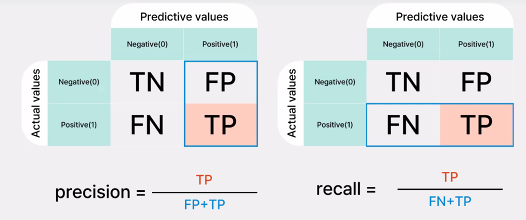

- 0 : 악성
- 1 : 양성

In [ ]:
confusion_matrix(y_test,pred_rfc)

array([[39,  3],
       [ 2, 70]], dtype=int64)

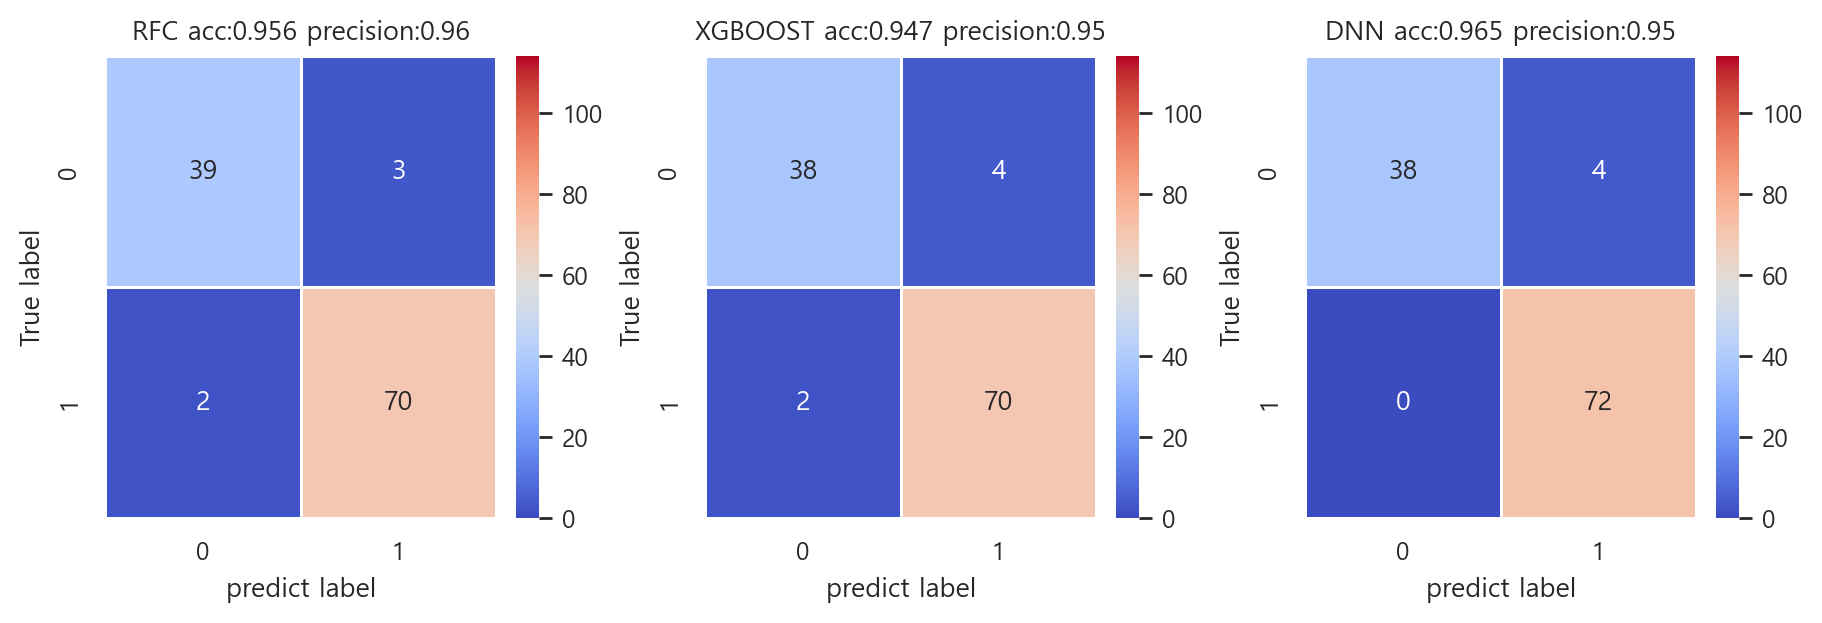

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (9,3))

pred_dict = {"RFC" : pred_rfc,
             "XGBOOST" : pred_xgb,
             "DNN" : pred_dnn}

for name, ax in zip (pred_dict.keys(), axes.flat):
    matrix = pred_dict[name]
    acc = round(metrics.accuracy_score(matrix, y_test), 3)
    precision = round(metrics.precision_score(y_test, matrix), 2)

    sns.heatmap(data = confusion_matrix(y_test, matrix),
                cmap="coolwarm",
                linecolor="white",
                linewidths=1,
                annot=True,
                vmax=114, #테스트 데이터의 개수가 114개 여서
                vmin=0,
                ax=ax)
    title = f"{name} acc:{acc} precision:{precision}"
    ax.set(xlabel = "predict label", ylabel = "True label", title = title)

# HR 데이터 

* 240529_03_hr.ipynb 참고

* no(재직): 0
* yes(퇴직): 1

In [ ]:
train = pd.read_csv("../data/hr_data/hr_train_scaling.csv",
                    index_col = 0)

test = pd.read_csv("../data/hr_data/hr_test_scaling.csv",
                    index_col = 0)

In [ ]:
x_train = train[train.columns[:-1]].values
y_train = train["attrition"].values

x_test = test[test.columns[:-1]].values
y_test = test["attrition"].values

In [ ]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (1094, 12)
y_train:  (1094,)
x_test:  (365, 12)
y_test:  (365,)


## k-NN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(x_train, y_train)
pred_knn = knn.predict(x_test)
print('The accuracy of the KNN is', metrics.accuracy_score(pred_knn, y_test))

The accuracy of the KNN is 0.8328767123287671


## DT

In [ ]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print('The accuracy of the DT is', metrics.accuracy_score(pred_tree, y_test))

The accuracy of the DT is 0.7671232876712328


## RFC

In [ ]:
rfc_best = RandomForestClassifier(n_estimators = 200, 
                               oob_score = True,
                               random_state = 209,
                               max_depth = 3, 
                               max_features = None, 
                               min_samples_leaf = 7,
                               min_samples_split = 6)

rfc_best.fit(x_train, y_train)
pred_rfc = rfc_best.predict(x_test)
print('The accuracy of the RFC is', 
      metrics.accuracy_score(pred_rfc, y_test))

The accuracy of the RFC is 0.8273972602739726


## XGBoost

In [ ]:
xgb_best = XGBClassifier(booster = "gbtree", 
                    objective = "binary:logistic",
                    learning_rate = 0.0301, 
                    max_depth = 3, 
                    n_estimators = 250)

xgb_best.fit(x_train, y_train)
pred_xgb = xgb_best.predict(x_test)
print('The accuracy of the XGBoost is', 
      metrics.accuracy_score(pred_xgb, y_test))

The accuracy of the XGBoost is 0.8301369863013699


## 신경망

In [ ]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 12
# 출력노드 수
output_node = 1

#모델
dnn = Sequential(name = "hr_classifier")
dnn.add(Dense(output_node,
              kernel_initializer='he_normal',
              activation = "sigmoid",
              input_shape=(input_node,)
             ))

In [ ]:
adam = Adam(learning_rate=0.0005)

dnn.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics = ['accuracy'])

# validation loss가 연속 3번 감소하지 않으면 조기종료
early_stopping = EarlyStopping(patience = 3,
                               restore_best_weights=True)

In [ ]:
dnn_hist = dnn.fit(x_train, 
                   y_train,
                   epochs=40, 
                   batch_size=16, 
                   validation_split=0.2,
                   callbacks=[early_stopping]
                  )

Epoch 1/40
55/55 [==============================] - 1s 7ms/step - loss: 0.9377 - accuracy: 0.3177 - val_loss: 0.8491 - val_accuracy: 0.4018
Epoch 2/40
55/55 [==============================] - 0s 5ms/step - loss: 0.8716 - accuracy: 0.3383 - val_loss: 0.7953 - val_accuracy: 0.4155
Epoch 3/40
55/55 [==============================] - 0s 4ms/step - loss: 0.8126 - accuracy: 0.3771 - val_loss: 0.7496 - val_accuracy: 0.4475
Epoch 4/40
55/55 [==============================] - 0s 4ms/step - loss: 0.7604 - accuracy: 0.4194 - val_loss: 0.7086 - val_accuracy: 0.4749
Epoch 5/40
55/55 [==============================] - 0s 6ms/step - loss: 0.7139 - accuracy: 0.4651 - val_loss: 0.6737 - val_accuracy: 0.4977
Epoch 6/40
55/55 [==============================] - 0s 5ms/step - loss: 0.6732 - accuracy: 0.5177 - val_loss: 0.6431 - val_accuracy: 0.5525
Epoch 7/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.5886 - val_loss: 0.6172 - val_accuracy: 0.6438
Epoch 8/40
55/55 [==

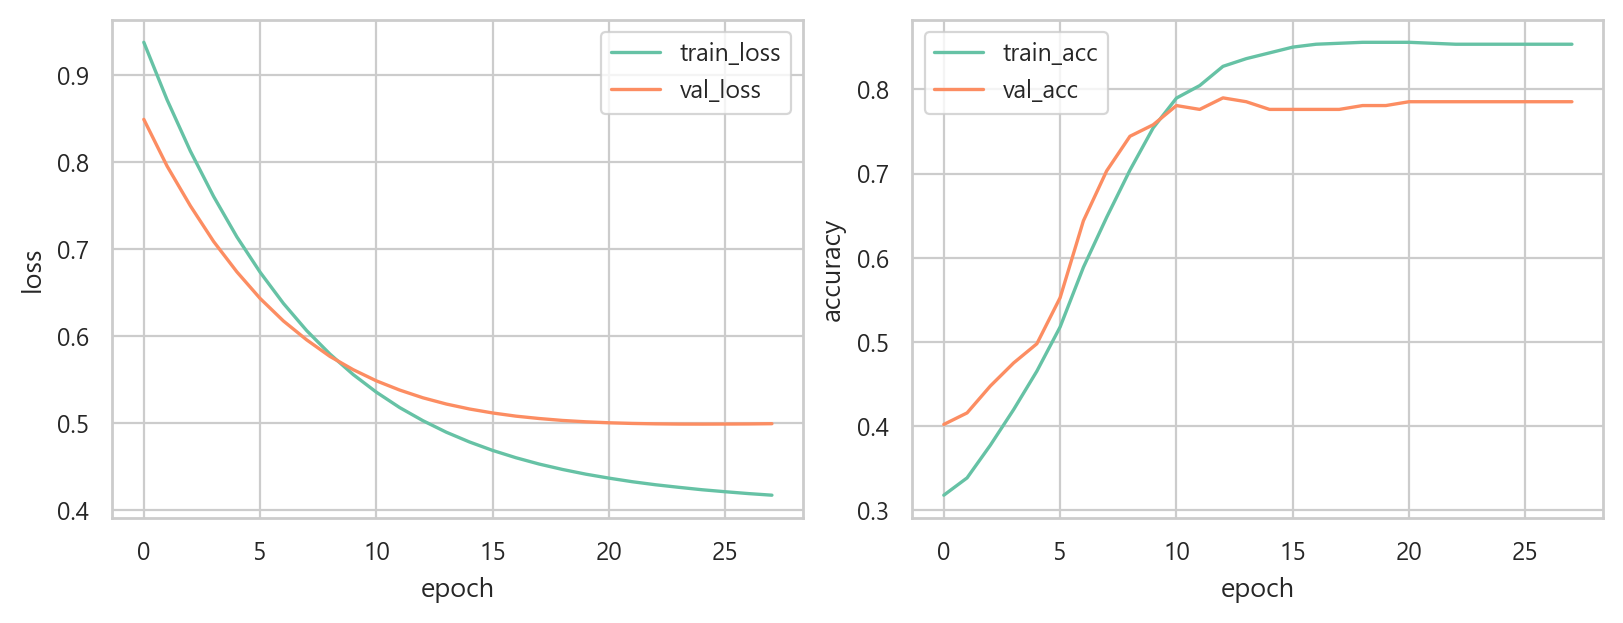

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(dnn_hist.history["loss"], label="train_loss")
ax_loss.plot(dnn_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch", ylabel = "loss")
ax_loss.legend()

ax_acc.plot(dnn_hist.history["accuracy"], label="train_acc")
ax_acc.plot(dnn_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch", ylabel = "accuracy")
ax_acc.legend();

In [ ]:
pred_dnn = dnn.predict(x_test).flatten() >= 0.5
print('The accuracy of the ANN is', 
      metrics.accuracy_score(pred_dnn, y_test))

12/12 [==============================] - 0s 2ms/step
The accuracy of the ANN is 0.8383561643835616


**테스트 데이터에 대한 정확도**

|model| ACC|
|:---|---:|
|k-NN| 0.833|
|DT| 0.767|
|RFC GridSearchCV| 0.827|
|XGBoost GridSearchCV| 0.830|
|ANN| 0.838|

c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


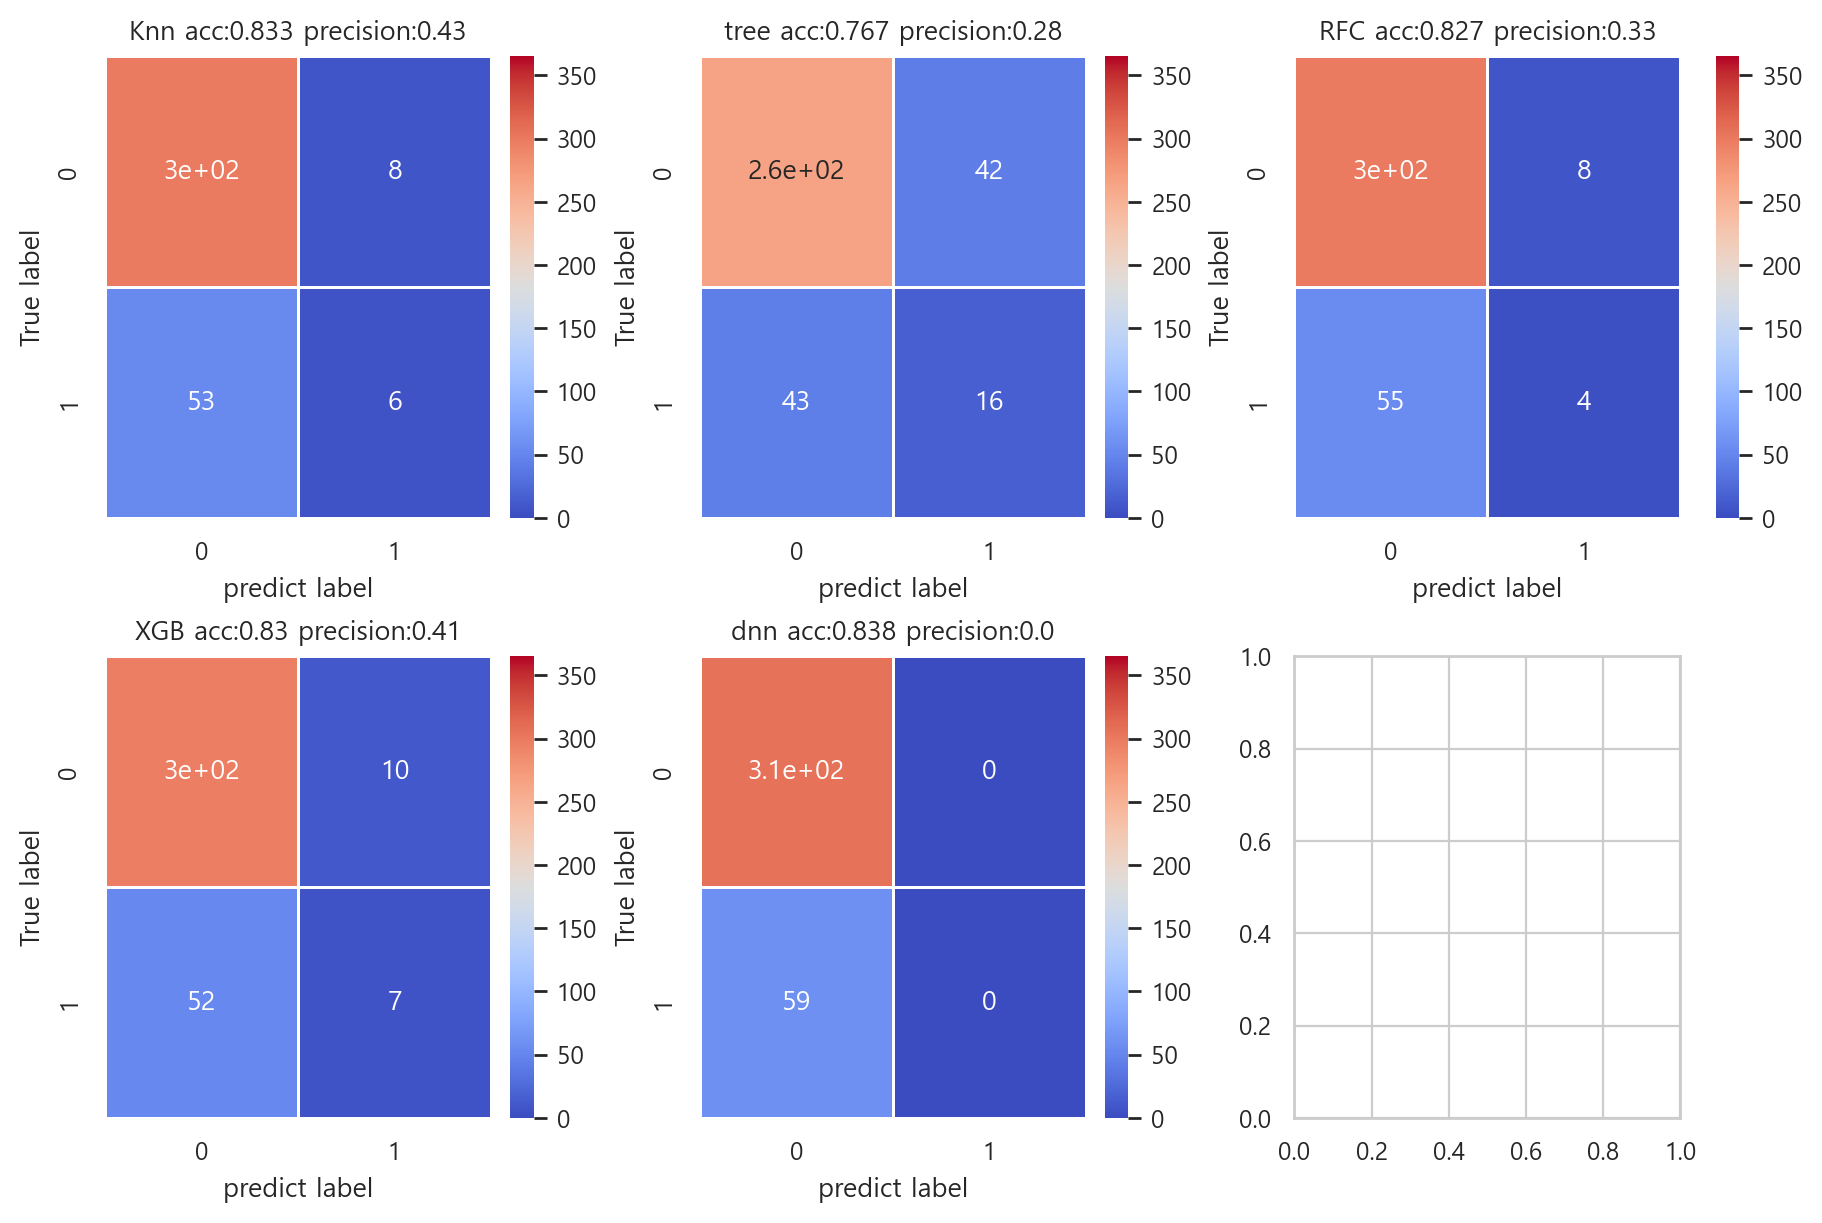

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (9,6))

pred_dict = {
               "Knn" : pred_knn,
               "tree": pred_tree,
               "RFC" : pred_rfc,
               "XGB" : pred_xgb,
               "dnn" : pred_dnn
             }

for name, ax in zip (pred_dict.keys(), axes.flat):
    matrix = pred_dict[name]
    acc = round(metrics.accuracy_score(matrix, y_test), 3)
    recall = round(metrics.precision_score(y_test, matrix), 2)

    sns.heatmap(data = confusion_matrix(y_test, matrix),
                cmap="coolwarm",
                linecolor="white",
                linewidths=1,
                annot=True,
                vmax=365, 
                vmin=0,
                ax=ax)
    title = f"{name} acc:{acc} precision:{recall}"
    ax.set(xlabel = "predict label", ylabel = "True label", title = title)

In [ ]:
print(classification_report(y_test, pred_tree))

# 주로 위의 두줄만 본다.

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       306
           1       0.28      0.27      0.27        59

    accuracy                           0.77       365
   macro avg       0.57      0.57      0.57       365
weighted avg       0.77      0.77      0.77       365



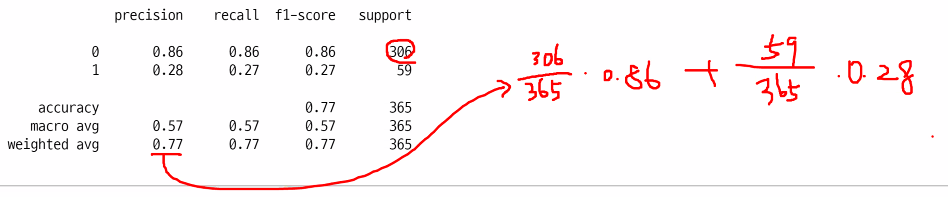

- 일반적인 accuracy는 산술평균

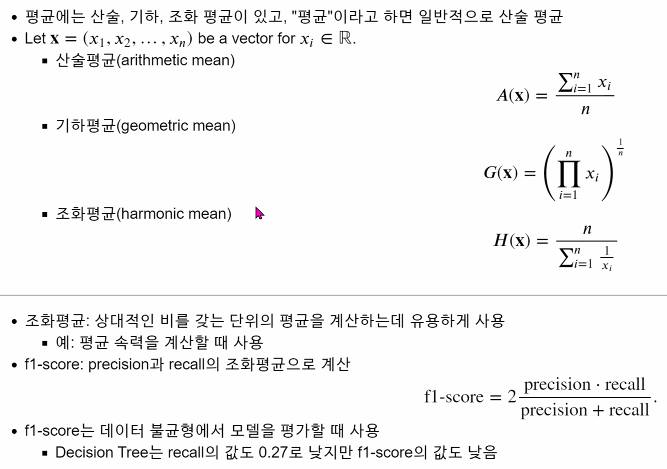

- 데이터 불균형이 높을때 f1 스코어를 쓴다
높으면 균형이 좋다

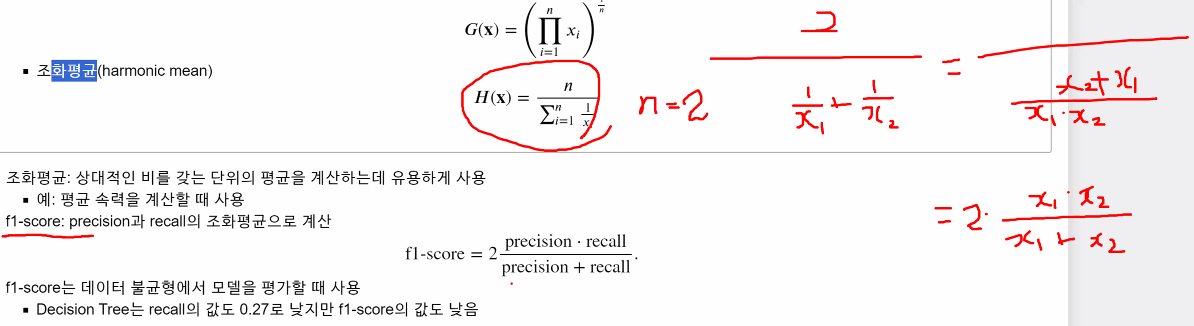